In [1]:
from __future__ import print_function
from keras.engine import Model
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


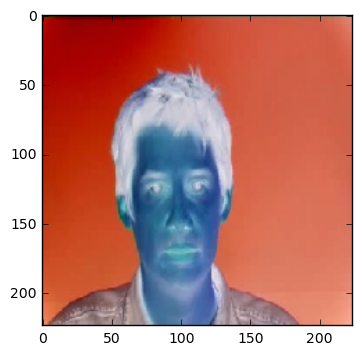

In [2]:
img = image.load_img('first_frame.jpg', target_size=(224,224))
x = image.img_to_array(img) # some fucked up color
plt.imshow(x)

The following pre-processing is similar to the built in pre_processing
for keras:

https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py

and is used in this feature extraction example:
https://keras.io/applications/#extract-features-with-vgg16

The author of this VGGFace library showed similar code (under prediction):
https://github.com/rcmalli/keras-vggface#example-usage

but it seems like the values they each used for zero-center is different


In [3]:
x = np.expand_dims(x, axis=0)
# tf order 'channel-last'
x = x[:, :, :, ::-1]

# Zero-center by mean pixel
x[:, :, :, 0] -= 93.5940
x[:, :, :, 1] -= 104.7624
x[:, :, :, 2] -= 129.1863

In [4]:
from keras.layers import Input

image_input = Input(shape=(224, 224, 3))
vgg_model_false = VGGFace(pooling='avg', include_top=False)
vgg_model_full = VGGFace()

In [5]:
mdl = Model(inputs=vgg_model_full.inputs, outputs=vgg_model_full.layers[18].output)

In [6]:
vgg_model_full.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [7]:
from keras import backend as K

In [8]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[2]
    imshape = imgs.shape[0:2]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic

In [124]:
#pl.imshow(make_mosaic(np.random.random((10, 10, 9)), 3, 3, border=1))

In [9]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

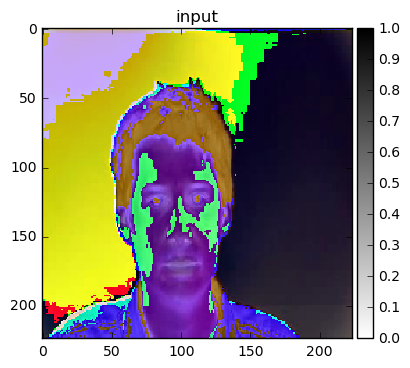

In [10]:
import pylab as pl
import matplotlib.cm as cm
pl.figure()
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(x), vmin=0, vmax=1, cmap=cm.binary)

In [11]:
inputs = [K.learning_phase()] + vgg_model_full.inputs

def convout_f(X, func):
    # The [0] is to disable the trianing phase flag
    return func([0] + [X])

# Layer 0

C0 shape :  (224, 224, 3)


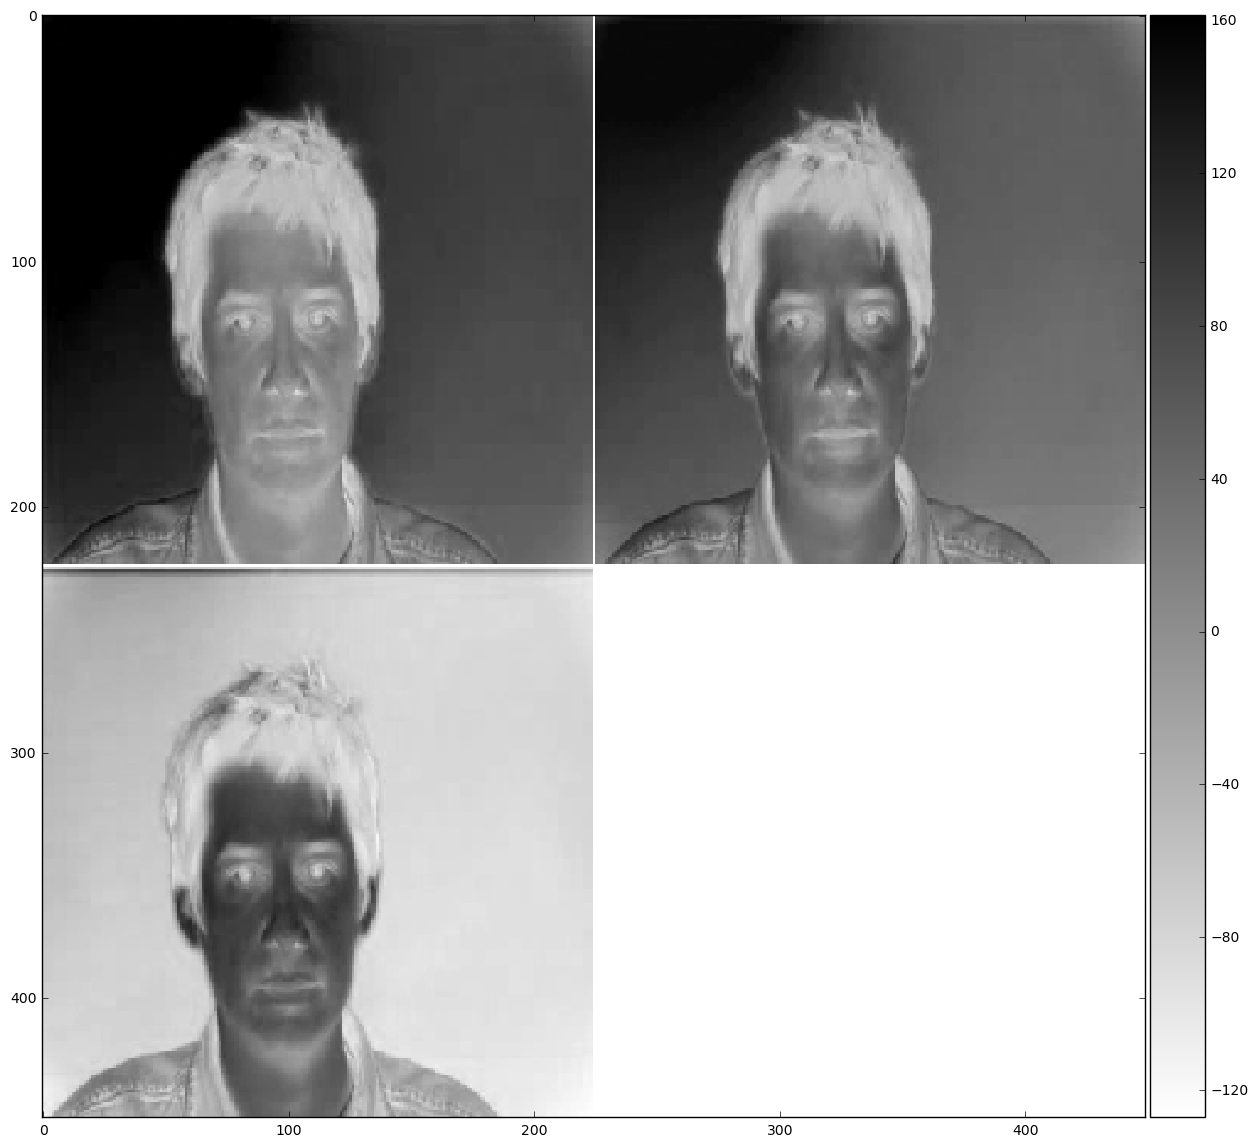

In [46]:
output0 = vgg_model_full.layers[0].output
_convout0_f = K.function(inputs, [output0])
C0 = convout_f(x, _convout0_f)
C0 = np.squeeze(C0)
print("C0 shape : ", C0.shape)

pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), make_mosaic(C0, 2, 2), cmap=cm.binary)

# Layer 2

C2 shape :  (224, 224, 64)


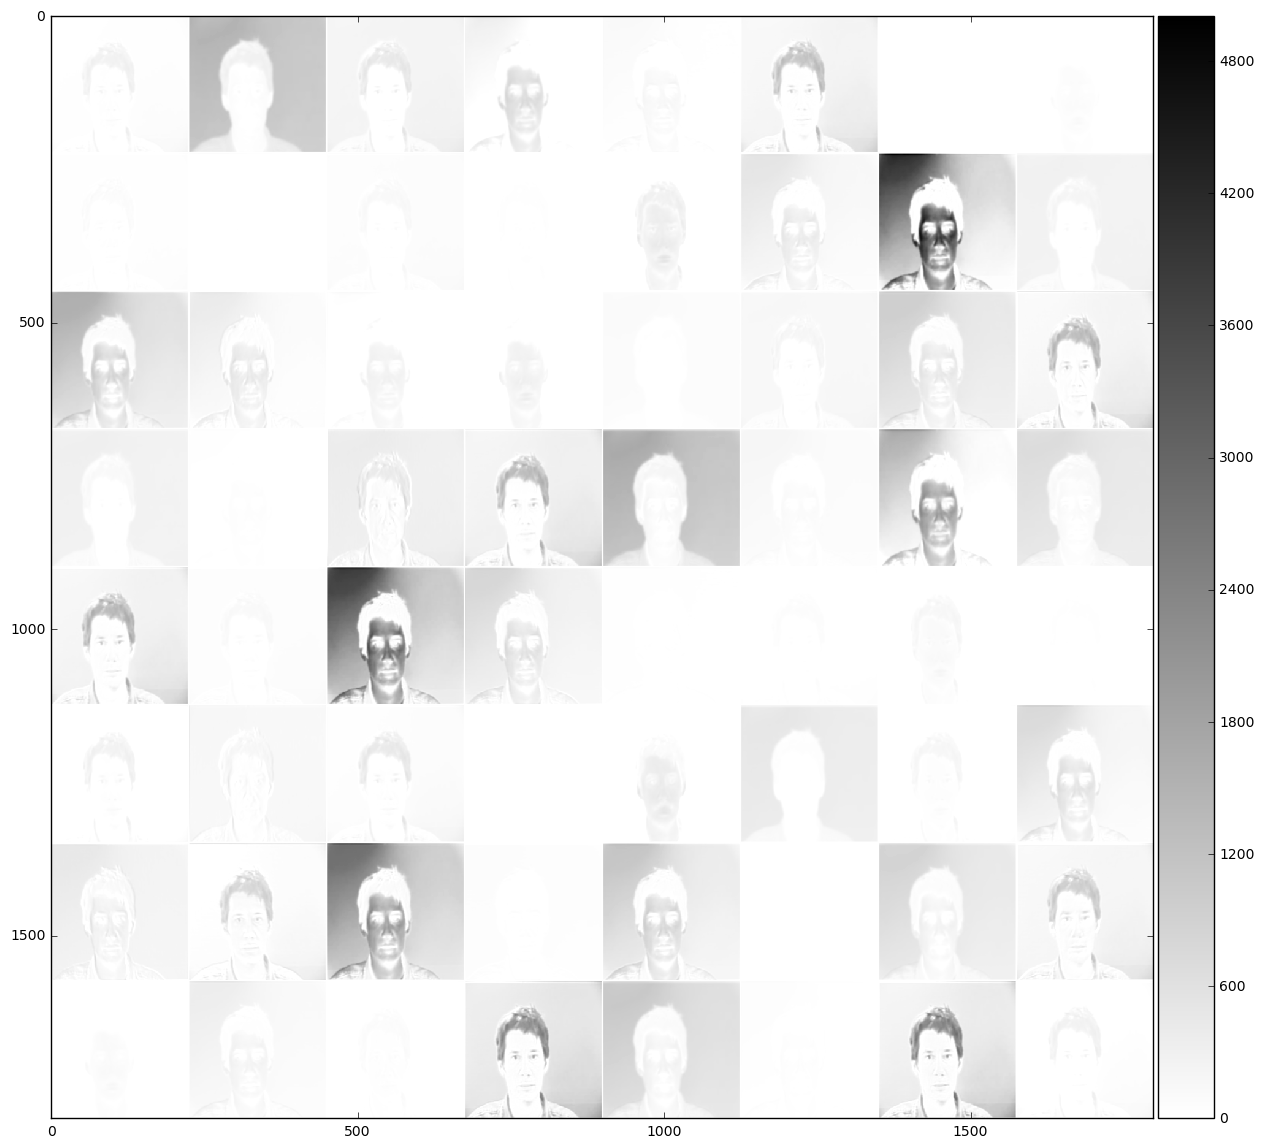

In [47]:
output2 = vgg_model_full.layers[2].output
_convout2_f = K.function(inputs, [output2])
C2 = convout_f(x, _convout2_f)
C2 = np.squeeze(C2)
print("C2 shape : ", C2.shape)

pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), make_mosaic(C2, 8, 8), cmap=cm.binary)

# Layer 6

C6 shape :  (56, 56, 128)


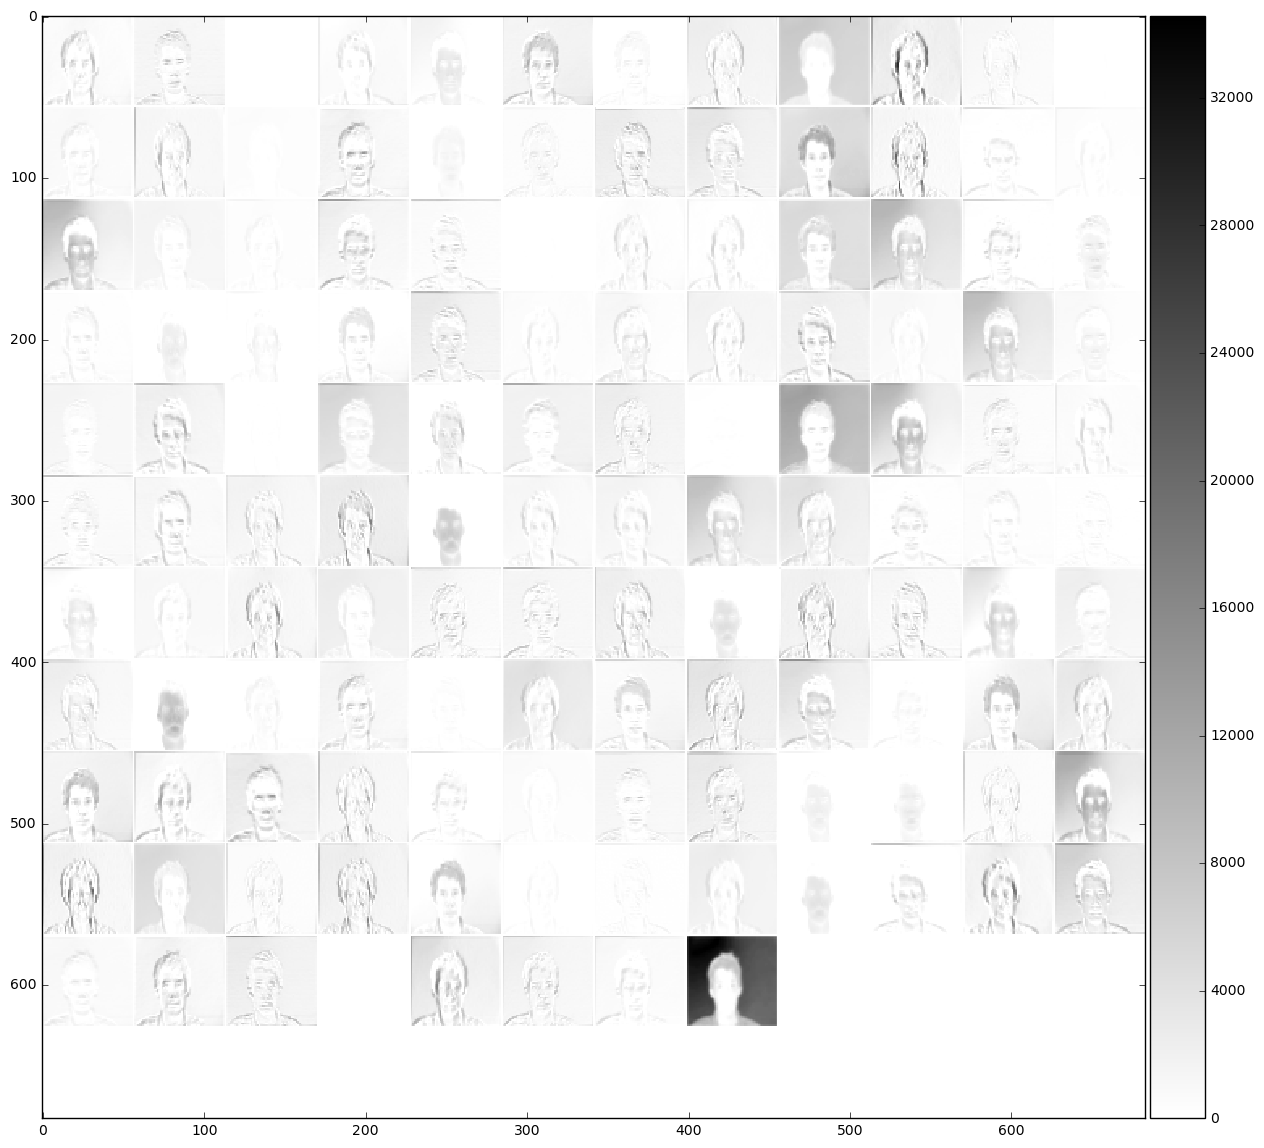

In [48]:
output6 = vgg_model_full.layers[6].output
_convout6_f = K.function(inputs, [output6])
C6 = convout_f(x, _convout6_f)
C6 = np.squeeze(C6)
print("C6 shape : ", C6.shape)

pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), make_mosaic(C6, 12, 12), cmap=cm.binary)

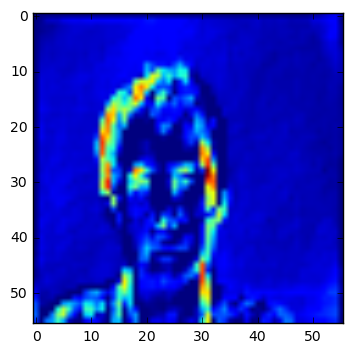

In [51]:
#nice_imshow(pl.gca(), C6[:,:,0], cmap=cm.binary)
plt.imshow(C6[:,:,0])

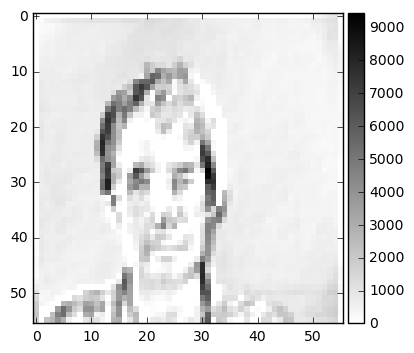

In [52]:
nice_imshow(pl.gca(), C6[:,:,0], cmap=cm.binary)

# Layer 9

C9 shape :  (56, 56, 256)


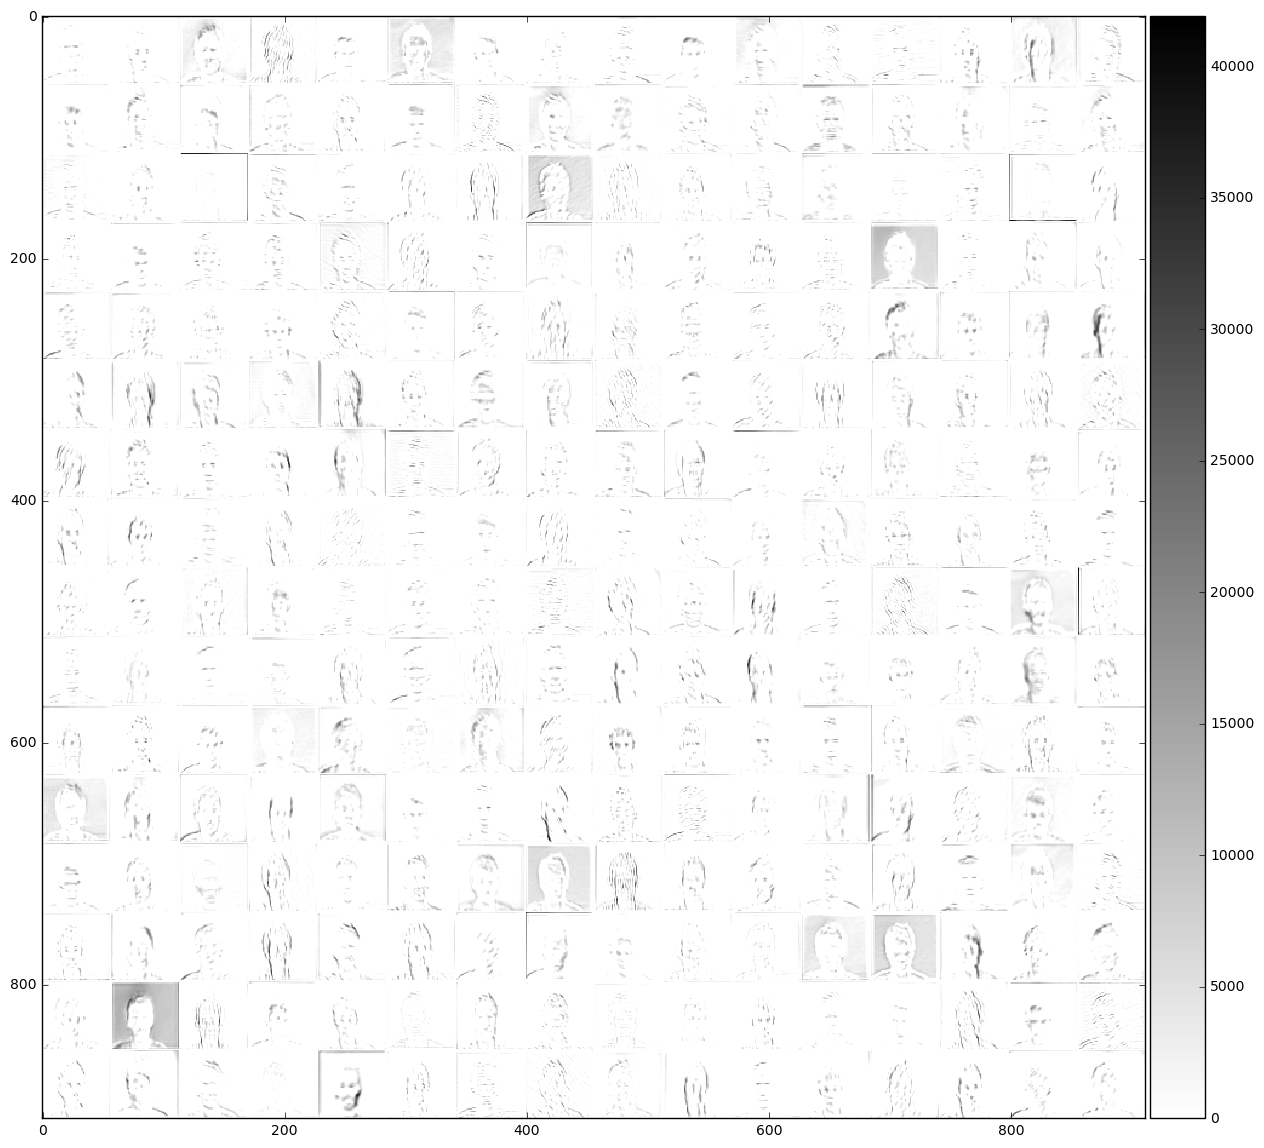

In [49]:
output9 = vgg_model_full.layers[9].output
_convout9_f = K.function(inputs, [output9])
C9 = convout_f(x, _convout9_f)
C9 = np.squeeze(C9)
print("C9 shape : ", C9.shape)

pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), make_mosaic(C9, 16, 16), cmap=cm.binary)

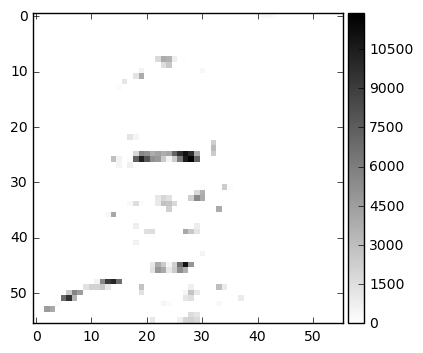

In [36]:
nice_imshow(pl.gca(), C9[:,:,0], cmap=cm.binary)

# Layer 10

C10 shape :  (28, 28, 256)


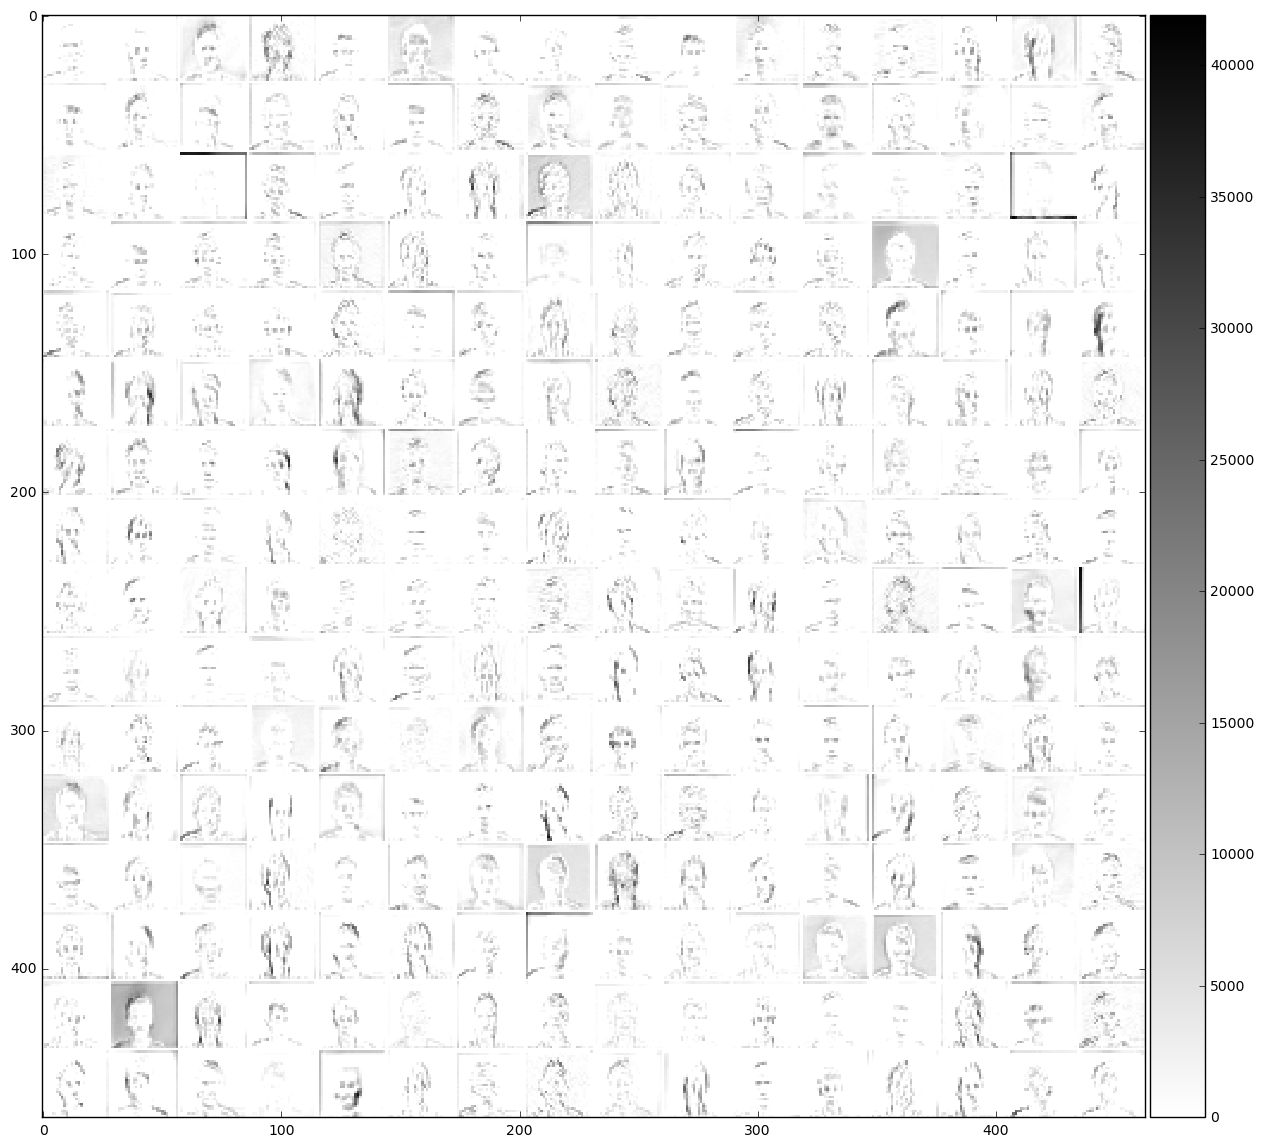

In [39]:
output10 = vgg_model_full.layers[10].output
_convout10_f = K.function(inputs, [output10])
C10 = convout_f(x, _convout10_f)
C10 = np.squeeze(C10)
print("C10 shape : ", C10.shape)

pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), make_mosaic(C10, 16, 16), cmap=cm.binary)

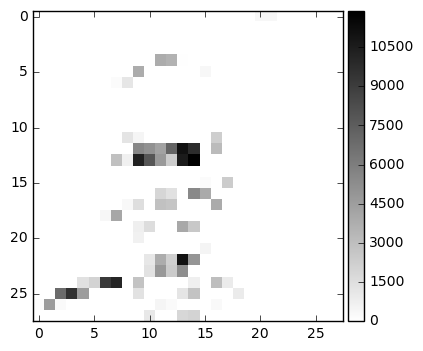

In [41]:
nice_imshow(pl.gca(), C10[:,:,0], cmap=cm.binary)

# Layer 13

C13 shape :  (28, 28, 512)


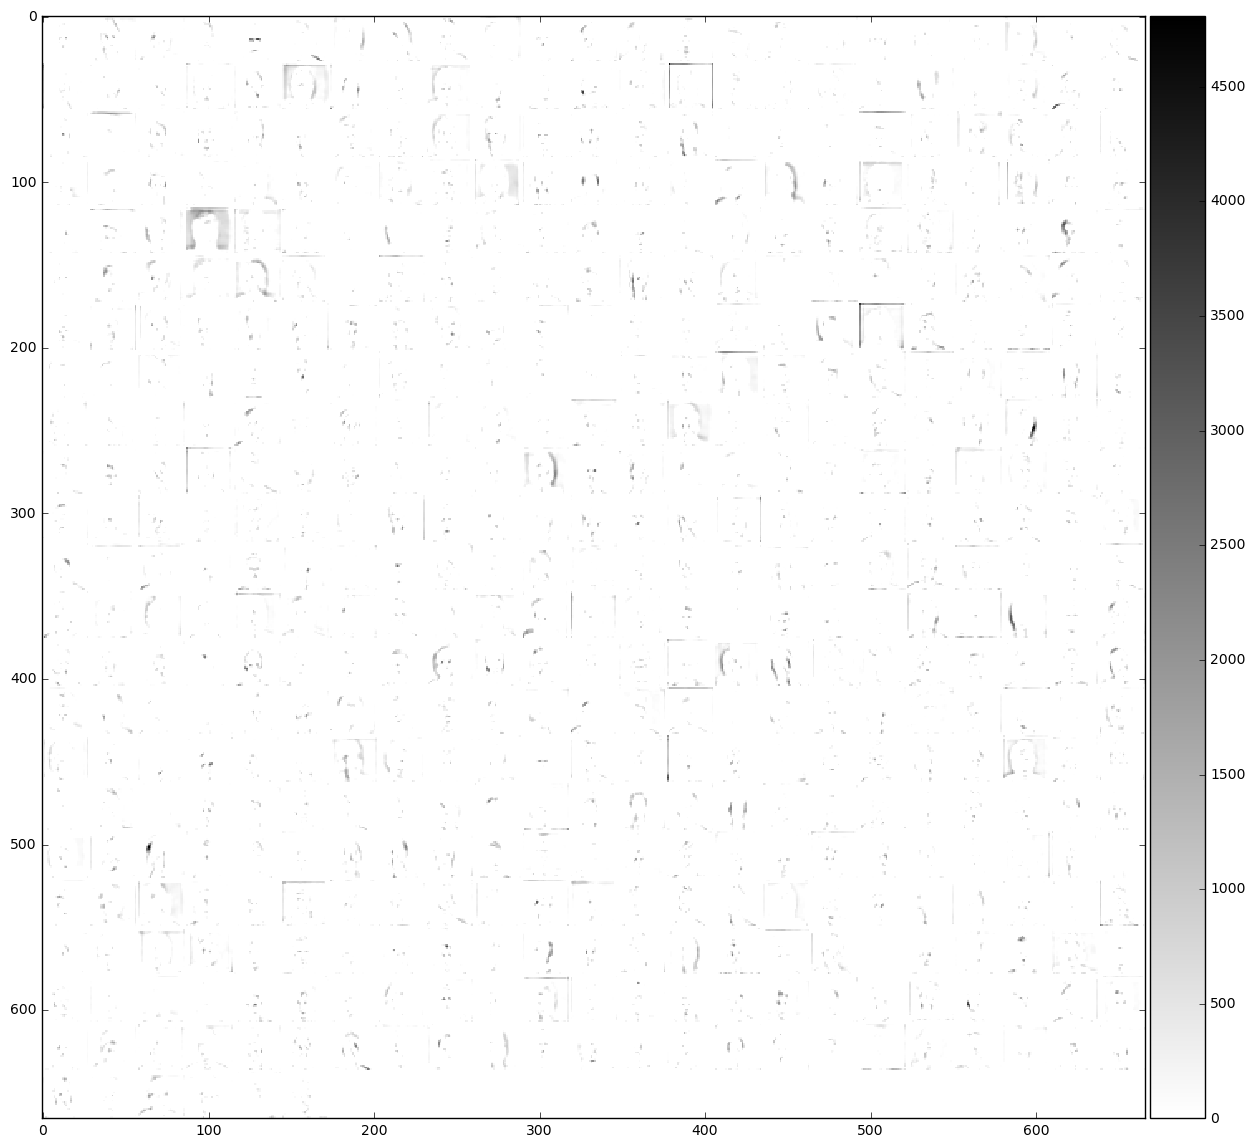

In [42]:
output13 = vgg_model_full.layers[13].output
_convout13_f = K.function(inputs, [output13])
C13 = convout_f(x, _convout13_f)
C13 = np.squeeze(C13)
print("C13 shape : ", C13.shape)

pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), make_mosaic(C13, 23, 23), cmap=cm.binary)

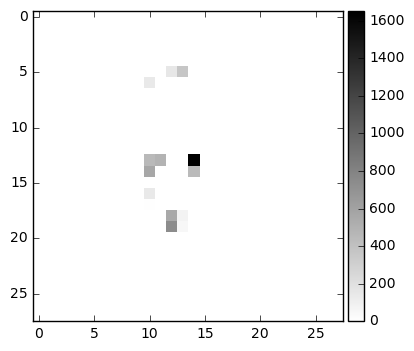

In [43]:
nice_imshow(pl.gca(), C13[:,:,0], cmap=cm.binary)

# Layer 14

C14 shape :  (14, 14, 512)


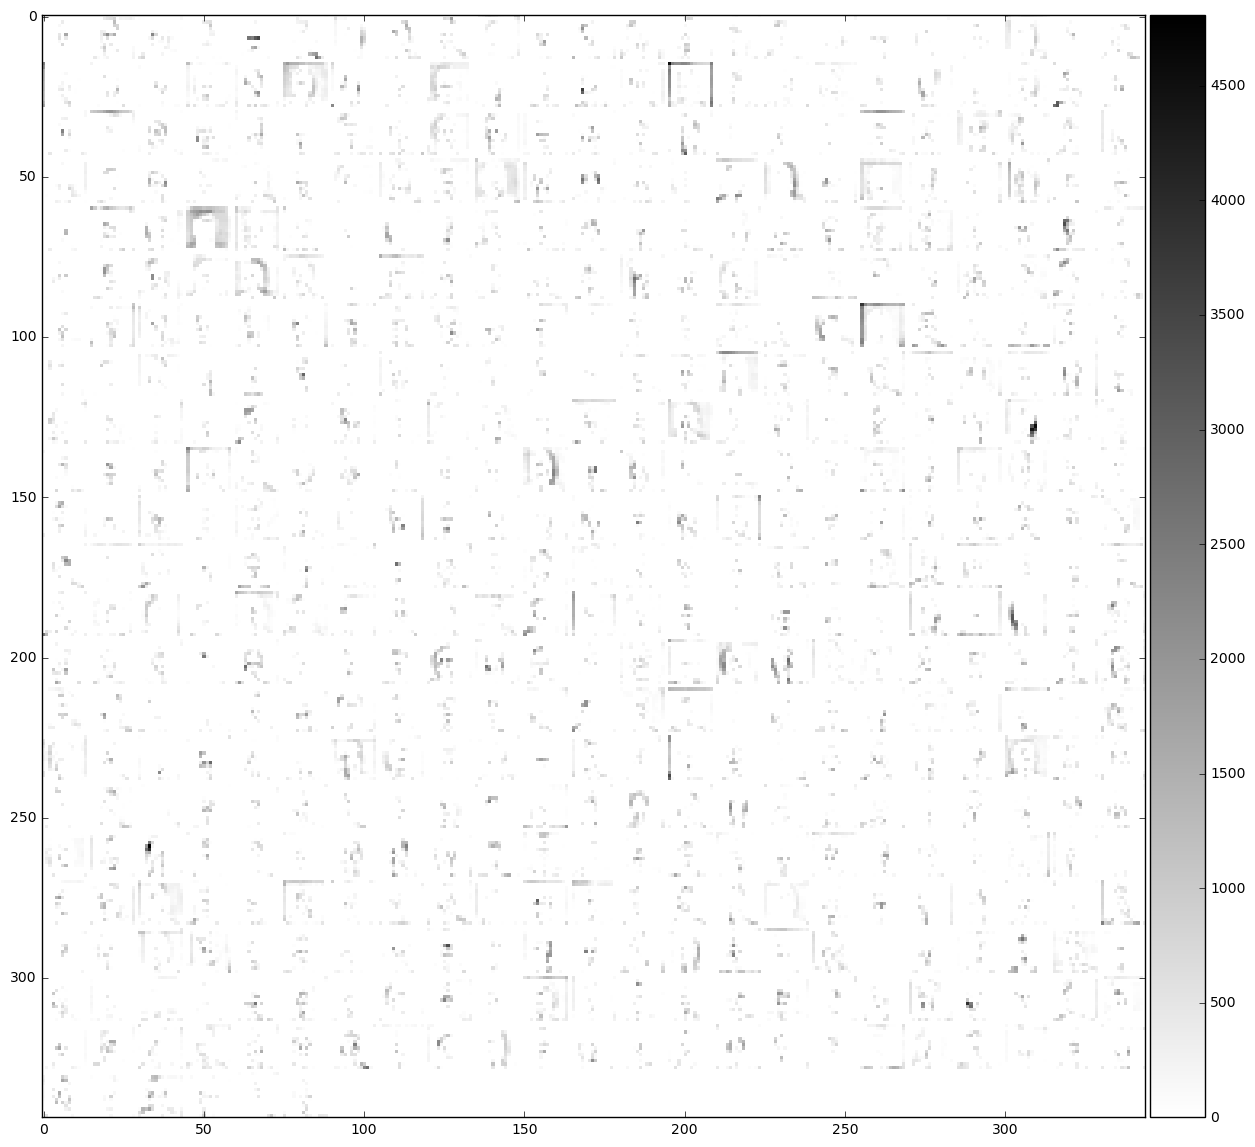

In [44]:
output14 = vgg_model_full.layers[14].output
_convout14_f = K.function(inputs, [output14])
C14 = convout_f(x, _convout14_f)
C14 = np.squeeze(C14)
print("C14 shape : ", C14.shape)

pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), make_mosaic(C14, 23, 23), cmap=cm.binary)

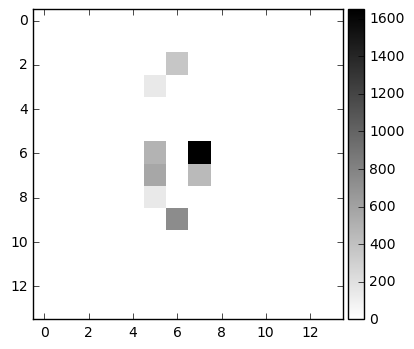

In [45]:
nice_imshow(pl.gca(), C14[:,:,0], cmap=cm.binary)

# Layer 18

C18 shape :  (7, 7, 512)


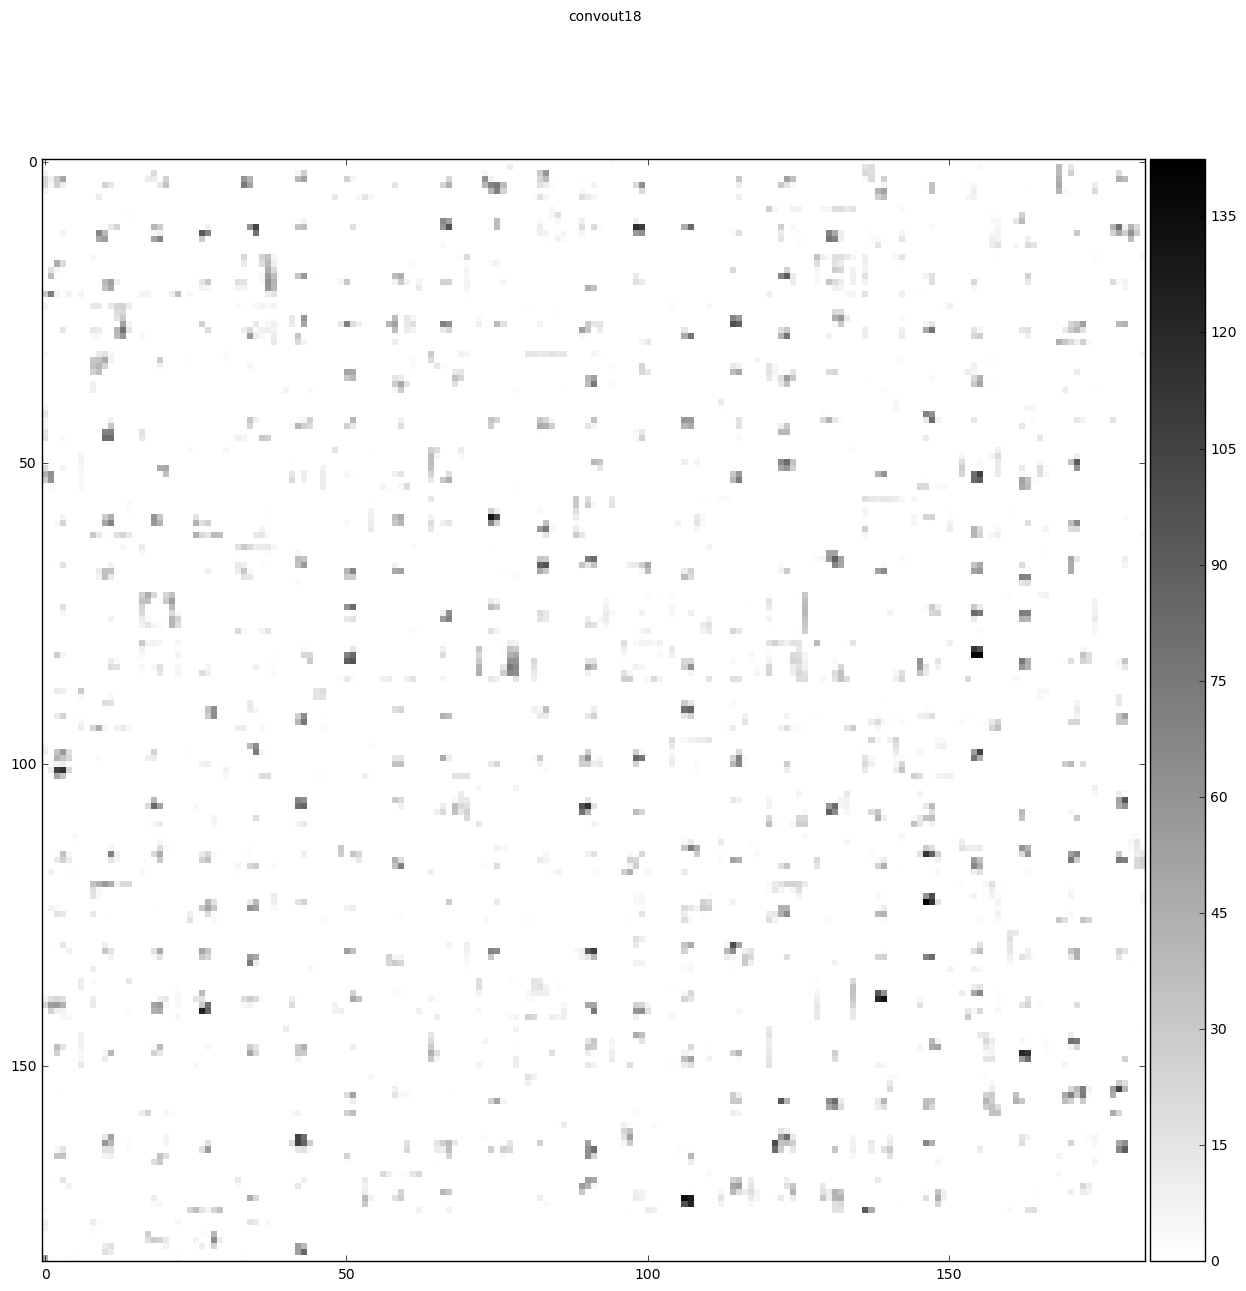

In [22]:
output18 = vgg_model_full.layers[18].output
_convout18_f = K.function(inputs, [output18])
C18 = convout_f(x, _convout18_f)
C18 = np.squeeze(C18)
print("C18 shape : ", C18.shape)

pl.figure(figsize=(15, 15))
nice_imshow(pl.gca(), make_mosaic(C18, 23, 23), cmap=cm.binary)

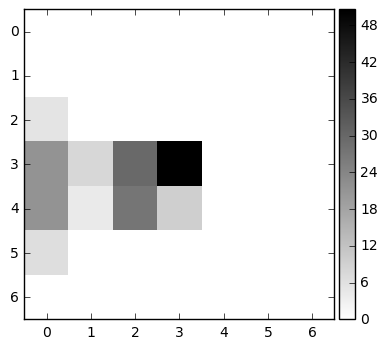

In [37]:
nice_imshow(pl.gca(), C18[:,:,0], cmap=cm.binary)

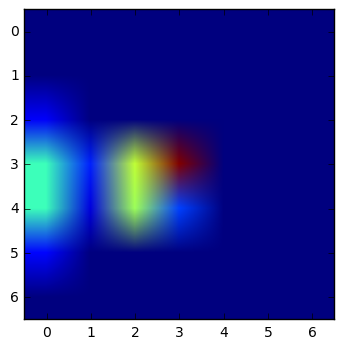

In [53]:
plt.imshow(C18[:,:,0])